# Transformer Chatbot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


     |████████████████████████████████| 2.3MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


## Global Constant Values

In [7]:
# Global constants
VERBOSE=True
MAX_NUMBER_OF_TOPICS = 20
MAX_TOPIC_WORD_COUNT = 1000
# Maximum number of samples to preprocess
MAX_SAMPLES = 250
# Maximum sentence length
MAX_LENGTH = 40
# Maximum number of features to be used for TFID
MAX_TFID_WORDS = 5000
# Topic Attention Mode
TOPIC_ATTENTION_MODE = False
# Drive data path
DRIVE_DATA_INPUT_PATH = '/content/drive/My Drive/Berkeley/W266/final_project/'


##Prepare Dataset

We will use the conversations in movies and TV shows provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of associated with each conversation ID. 


In [8]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

### Load and preprocess data

We are limiting the maximum number of training samples to`MAX_SAMPLES=50000` and the maximum length of the sentence to be `MAX_LENGTH=40`.

We preprocess our dataset in the following order:
* Extract `MAX_SAMPLES` conversation pairs into list of `questions` and `answers.
* Preprocess each sentence by removing special characters in each sentence.
* Build tokenizer (map text to ID and ID to text) using [TensorFlow Datasets SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).
* Tokenize each sentence and add `START_TOKEN` and `END_TOKEN` to indicate the start and end of each sentence.
* Filter out sentence that has more than `MAX_LENGTH` tokens.
* Pad tokenized sentences to `MAX_LENGTH`



In [9]:
# Maximum number of samples to preprocess

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence


def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations()

In [10]:
print('Sample question: {}'.format(questions[0]))
print('Sample answer: {}'.format(answers[0]))

Sample question: can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
Sample answer: well , i thought we d start with pronunciation , if that s okay with you .


## SubwordTextEncoder for word embedding

In [ ]:
# # Build tokenizer using tfds for both questions and answers
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     questions + answers, target_vocab_size=2**13)

# # Define start and end token to indicate the start and end of a sentence
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# # Vocabulary size plus start and end token
# VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
# print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

In [ ]:
# # Maximum sentence length
# MAX_LENGTH = 40


# # Tokenize, filter and pad sentences
# def tokenize_and_filter(inputs, outputs):
#   tokenized_inputs, tokenized_outputs = [], []
  
#   for (sentence1, sentence2) in zip(inputs, outputs):
#     # tokenize sentence
#     sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
#     sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
#     # check tokenized sentence max length
#     if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#       tokenized_inputs.append(sentence1)
#       tokenized_outputs.append(sentence2)
  
#   # pad tokenized sentences
#   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
#   return tokenized_inputs, tokenized_outputs


# questions, answers = tokenize_and_filter(questions, answers)

## Glove Embedding Data processing

In [11]:


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=200000)
texts = questions + answers
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [len(tokenizer.word_index) + 1], [len(tokenizer.word_index) + 2]

# Vocabulary size plus start and end token
VOCAB_SIZE = len(tokenizer.word_index) + 3

print('Vocabulary Size: ', VOCAB_SIZE)
print('Tokenized sample question: {}'.format(tokenizer.texts_to_sequences(questions)))


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  inputs = tokenizer.texts_to_sequences(inputs)
  outputs = tokenizer.texts_to_sequences(outputs)
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + sentence1 + END_TOKEN
    sentence2 = START_TOKEN + sentence2 + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs


sequenced_questions, sequenced_answers = tokenize_and_filter(questions, answers)

embeddings_index = {}
# GLOVE_DIR = '/Users/param/Documents/Berkeley/W266/final_project/data/'
GLOVE_DIR = '/content/drive/My Drive/Berkeley/W266/final_project/data'

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 100
# embedding matrix is of size vocab_size + Embedding dimension
embedding_matrix = np.zeros((len(word_index) + 3, EMBEDDING_DIM))
sequence_to_word_dict = {}
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    sequence_to_word_dict.update( {i : word} )
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print('embedding_matrix shape:', embedding_matrix.shape)

Found 902 unique tokens.
Vocabulary Size:  905
Tokenized sample question: [[36, 22, 106, 41, 501, 502, 503, 11, 504, 505, 51, 278, 73, 279, 506, 280, 212, 52, 39, 5, 507, 281], [118, 2, 68, 22, 40, 166, 23, 282, 44, 7, 6, 107, 23, 1], [15, 5, 283, 11, 284, 11, 285, 145, 286], [1, 13, 508, 16, 17, 7, 6, 34, 509, 20, 6, 30, 510, 281], [37, 37, 9, 6, 27, 511, 22, 90, 8, 35, 4, 512, 513], [108], [5, 119, 31, 108, 2, 21, 59, 5, 287, 12, 4, 288, 289, 290, 12, 291, 27, 48, 2, 36, 8, 49, 109, 14, 74], [64], [292, 293, 14, 213, 3, 55, 81, 294, 91, 14, 295, 146, 61, 60, 9, 38, 18, 24, 14, 56, 296, 12, 9, 99, 120], [514, 44, 147, 22, 92, 214, 121, 4, 122], [297, 515, 516, 517, 41, 31, 27, 148], [93, 94, 1, 13, 215, 28, 5, 298], [2, 45, 8, 43, 3, 32, 50, 3, 82, 7, 167, 2, 43, 3, 32, 299, 168, 24, 95, 5, 83, 300, 51, 50, 216, 74, 301, 302, 110, 24, 123, 2, 35, 53, 33, 27, 217, 96, 3, 169, 17, 27, 148, 3, 124], [7, 6, 75, 9, 6, 303, 4, 218, 47], [50, 31, 304, 149, 214, 5, 518, 4, 49, 170, 519], [100

In [12]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))
print('Sequence to word with index 10:', sequence_to_word_dict.get(1))

Vocab size: 905
Number of samples: 250
Sequence to word with index 10: you


# Topic Dataset and NMF topic matrix generation

In [13]:
# Topic data set based on shakespeare plays
# allData = pd.read_csv('./data/Shakespeare_data.csv', sep=',')
allData = pd.read_csv(DRIVE_DATA_INPUT_PATH + 'data/Shakespeare_data.csv', sep=',')
allData.columns = ["Dataline","Play","PlayerLinenumber","ActSceneLine","Player","PlayerLine"]
allData = list(allData.PlayerLine)

# convert the text to a tf-idf weighted term-document matrix
vectorizer = TfidfVectorizer(max_features=MAX_TFID_WORDS, min_df=10, stop_words='english')
X = vectorizer.fit_transform(allData)
idx_to_word = np.array(vectorizer.get_feature_names())

# apply NMF
nmf = NMF(n_components=MAX_NUMBER_OF_TOPICS, solver="mu")
W = nmf.fit_transform(X)
shakespeare_topic_matrix = nmf.components_

print('shakespeare_topic_matrix shape:\n', shakespeare_topic_matrix.shape)
print('shakespeare_topic_matrix:\n', shakespeare_topic_matrix)

# print the topics and create the topic word matrix
topic_word_matrix = np.zeros([MAX_NUMBER_OF_TOPICS, MAX_TOPIC_WORD_COUNT], dtype=int)
for i, topic in enumerate(shakespeare_topic_matrix):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))
    count = 0
    for x in topic.argsort()[- MAX_TOPIC_WORD_COUNT:]:
        topic_word_matrix[i][count] = x
        count += 1
print(topic_word_matrix.shape)

shakespeare_topic_matrix shape:
 (20, 4915)
shakespeare_topic_matrix:
 [[5.60895433e-17 1.32168228e-12 1.27328572e-03 ... 1.22781558e-03
  5.07508696e-10 4.03190607e-16]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.76475163e-03 1.12966648e-07 6.58745839e-23 ... 4.86862967e-11
  7.73187592e-17 1.26756346e-03]
 ...
 [0.00000000e+00 1.93727043e-04 0.00000000e+00 ... 5.00519170e-04
  9.63603294e-04 2.71469177e-09]
 [2.68392728e-03 1.35998676e-04 5.79285164e-19 ... 2.44523269e-03
  3.51856831e-03 4.26783087e-04]
 [1.87545817e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.94590255e-03 8.14604551e-06]]
Topic 1: angelo,lady,tis,honour,tell,dear,gracious,noble,ay,lord
Topic 2: polonius,guarded,messenger,body,gentleman,bardolph,falstaff,attendant,servant,exit
Topic 3: canst,didst,speak,shalt,wilt,dost,st,hast,art,thou
Topic 4: hamlet,citizens,train,servants,gloucester,lords,attendants,severally,flourish,exeunt
Topic 5: die,day,s

## Create the topic word embedding vector
Create the topic embedding vector using the weighted averages of the embedding values of the words per topic based on the embedding from glove. This will create a matrix of dimension [Number of Topics x Embedding Dimension]

In [14]:
def createTopicWordEmbeddings():
    topic_word_embeddings = np.zeros((MAX_NUMBER_OF_TOPICS, EMBEDDING_DIM), dtype='float')
    for topic_index in range(0, MAX_NUMBER_OF_TOPICS):
        current_topic_value = 0.0
        current_topic = shakespeare_topic_matrix[topic_index]
        topic_words = idx_to_word[current_topic.argsort()[-MAX_TOPIC_WORD_COUNT:]]
        current_topic_value_count = 0.0
        for index in range(0, MAX_TOPIC_WORD_COUNT):
            if embeddings_index.get(topic_words[index]) is not None:
                current_topic_value += embeddings_index.get(topic_words[index]) * current_topic[index]
                current_topic_value_count += current_topic[index]
        if current_topic_value_count > 0:
            current_topic_value = current_topic_value / current_topic_value_count

        topic_word_embeddings[topic_index] = current_topic_value
    print(topic_word_embeddings)
    return topic_word_embeddings

topic_word_embeddings = createTopicWordEmbeddings()

[[-0.01532125  0.06433101  0.11627214 ... -0.22593327  0.04153866
  -0.05308861]
 [-0.03556896  0.19782509  0.17044756 ... -0.01461926  0.28753564
   0.00073161]
 [-0.18248567  0.10525098  0.02601547 ... -0.06323586 -0.0022872
   0.1268585 ]
 ...
 [-0.04341035  0.19278826  0.26967353 ... -0.14597702  0.12687531
   0.10445166]
 [ 0.00383897  0.12726277  0.1965431  ... -0.10622136  0.12569796
   0.14154193]
 [-0.01162911  0.18323545  0.23072572 ... -0.19164768  0.13251586
   0.04078618]]


### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

validation_percent = 10
# print(sequenced_questions)
validation_record_count = int((validation_percent * sequenced_questions.shape[0])/100)
validation_questions = sequenced_questions[-validation_record_count:]
validation_answers = sequenced_answers[-validation_record_count:]
train_questions = sequenced_questions[:-validation_record_count]
train_answers = sequenced_answers[:-validation_record_count]

test_percent = 10
test_record_count = int((test_percent * train_questions.shape[0])/100)
test_questions = train_questions[-test_record_count:]
test_answers = train_answers[-test_record_count:]
train_questions = train_questions[:-test_record_count]
train_answers = train_answers[:-test_record_count]

print('train_questions shape:', train_questions.shape)
print('train_answers shape:', train_answers.shape)
print('validation_questions shape:', validation_questions.shape)
print('validation_answers shape:', validation_answers.shape)
print('test_questions shape:', test_questions.shape)
print('test_answers shape:', test_answers.shape)

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_questions,
        'dec_inputs': train_answers[:, :-1]
    },
    {
        'outputs': train_answers[:, 1:]
    },
))

train_dataset = train_dataset.cache()
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': validation_questions,
        'dec_inputs': validation_answers[:, :-1]
    },
    {
        'outputs': validation_answers[:, 1:]
    },
))

validation_dataset = validation_dataset.cache()
# validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_questions shape: (199, 40)
train_answers shape: (199, 40)
validation_questions shape: (24, 40)
validation_answers shape: (24, 40)
test_questions shape: (22, 40)
test_answers shape: (22, 40)


## Attention



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [17]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

## Topic based scaled dot product attention

In [18]:
def scaled_dot_product_attention_for_topic(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  # if mask is not None:
  #   print('scaled_dot_product_attention mask:', mask)
  #   logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

  def get_config(self):
    return {"d_model": self.d_model, "num_heads":self.num_heads}        

## MultiHeadAttention for Topic Attention

In [20]:
class MultiHeadAttentionForTopic(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttentionForTopic, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]
    max_record_length = tf.shape(query)[1] - 1

    topic_constant = tf.keras.backend.expand_dims(tf.keras.backend.constant(topic_word_embeddings, name='topic_key'), 0)
    key = topic_constant
    value = topic_constant

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention_for_topic(query, key, value, mask)

    # final linear layer
    outputs = self.dense(scaled_attention)
    return outputs

  def get_config(self):
    return {"d_model": self.d_model, "num_heads":self.num_heads}    

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [21]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [23]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [25]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

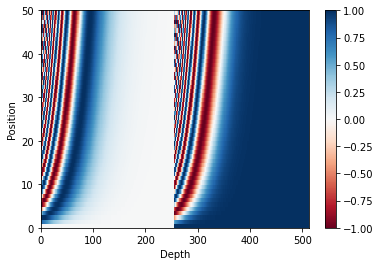

In [26]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [27]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

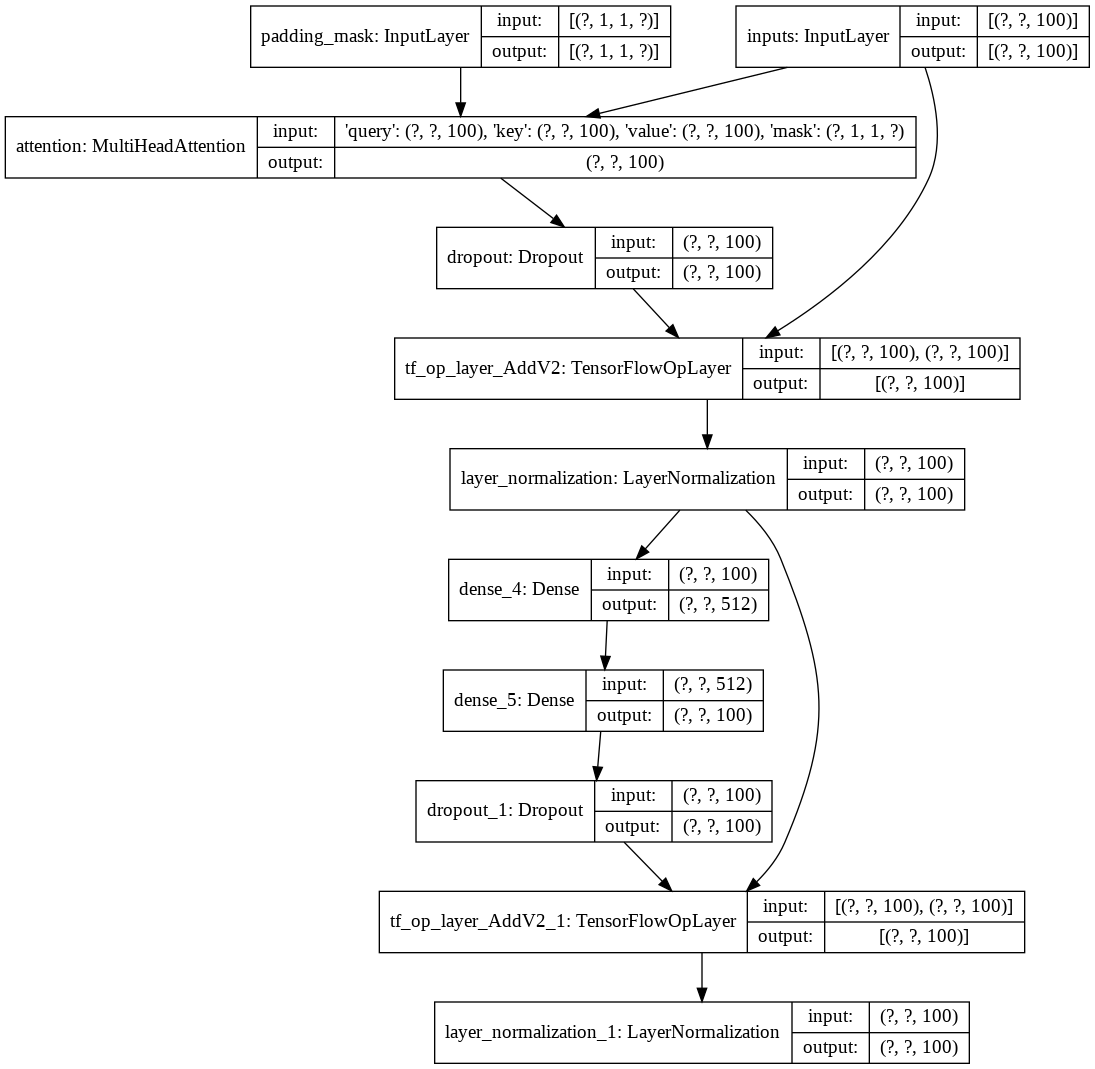

In [28]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=100,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings = tf.keras.layers.Embedding(len(word_index) + 3,
                          EMBEDDING_DIM,
                          # d_model,
                          # embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                          weights=[embedding_matrix],
                          input_length=MAX_LENGTH,
                          trainable=False)(inputs)  
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

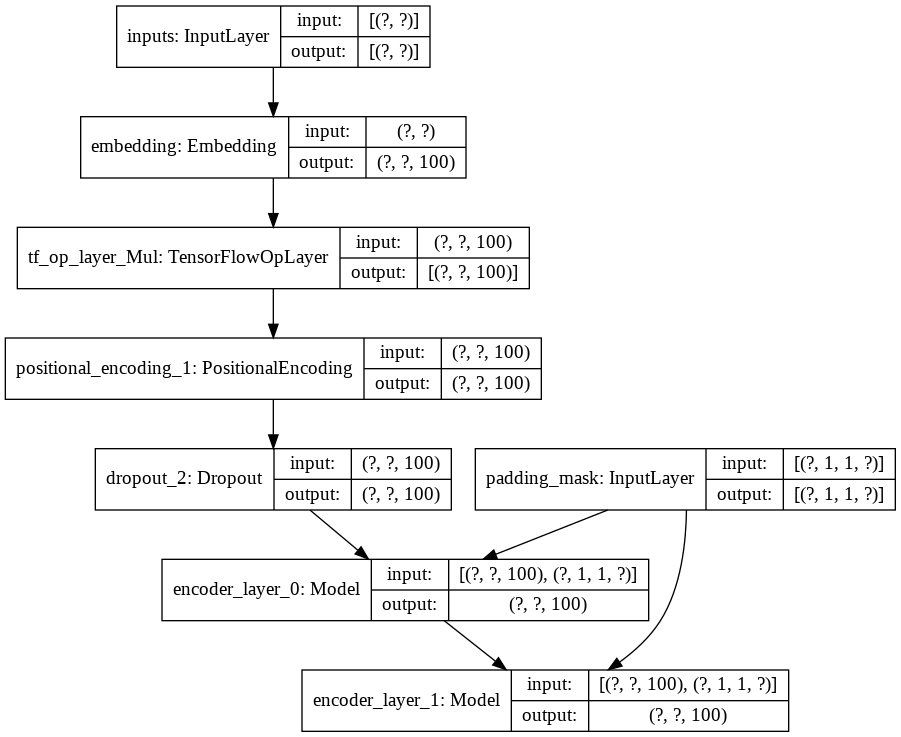

In [30]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=100,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

## Decoder layer with the additional topic attention layer added to it

In [31]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  print('Decoder Layer inputs:', inputs)

  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  print('Decoder Layer enc_outputs:', enc_outputs)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  print('Decoder Layer look_ahead_mask:', look_ahead_mask)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  print('Decoder Layer padding_mask:', padding_mask)

  # print('Decoder Layer topics:', topics)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  print('Decoder Layer attention1:', attention1)
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)
  print('Decoder Layer attention1 - 2:', attention1)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  print('Decoder Layer attention2:', attention2)
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  print('Decoder Layer attention2 - 2:', attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)
  print('Decoder Layer attention2 - 3:', attention2)

  attention3 = attention2
  if TOPIC_ATTENTION_MODE:
      attention3 = MultiHeadAttentionForTopic(
          d_model, num_heads, name="attention_3")(inputs={
          'query': attention2,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

      print('Decoder Layer attention3:', attention3)
      attention3 = tf.keras.layers.Dropout(rate=dropout)(attention3)
      print('Decoder Layer attention3 - 2:', attention3)
      attention3 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention3 + attention2)

  print('Decoder Layer attention3:', attention3)
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention3)
  print('Decoder Layer outputs:', outputs)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  print('Decoder Layer outputs - 2:', outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  print('Decoder Layer outputs - 3:', outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention3)  
  print('Decoder Layer outputs - 4:', outputs)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], # TOPIC RELATED
      outputs=outputs,
      name=name)

Decoder Layer inputs: Tensor("inputs_4:0", shape=(None, None, 100), dtype=float32)
Decoder Layer enc_outputs: Tensor("encoder_outputs:0", shape=(None, None, 100), dtype=float32)
Decoder Layer look_ahead_mask: Tensor("look_ahead_mask:0", shape=(None, 1, None, None), dtype=float32)
Decoder Layer padding_mask: Tensor("padding_mask_4:0", shape=(None, 1, 1, None), dtype=float32)
Decoder Layer attention1: Tensor("attention_1_1/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention1 - 2: Tensor("layer_normalization_6/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2: Tensor("attention_2_1/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 2: Tensor("dropout_7/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 3: Tensor("layer_normalization_7/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention3: Tensor("layer_normalization_7/Identity:0", shape=(None, None, 100), 

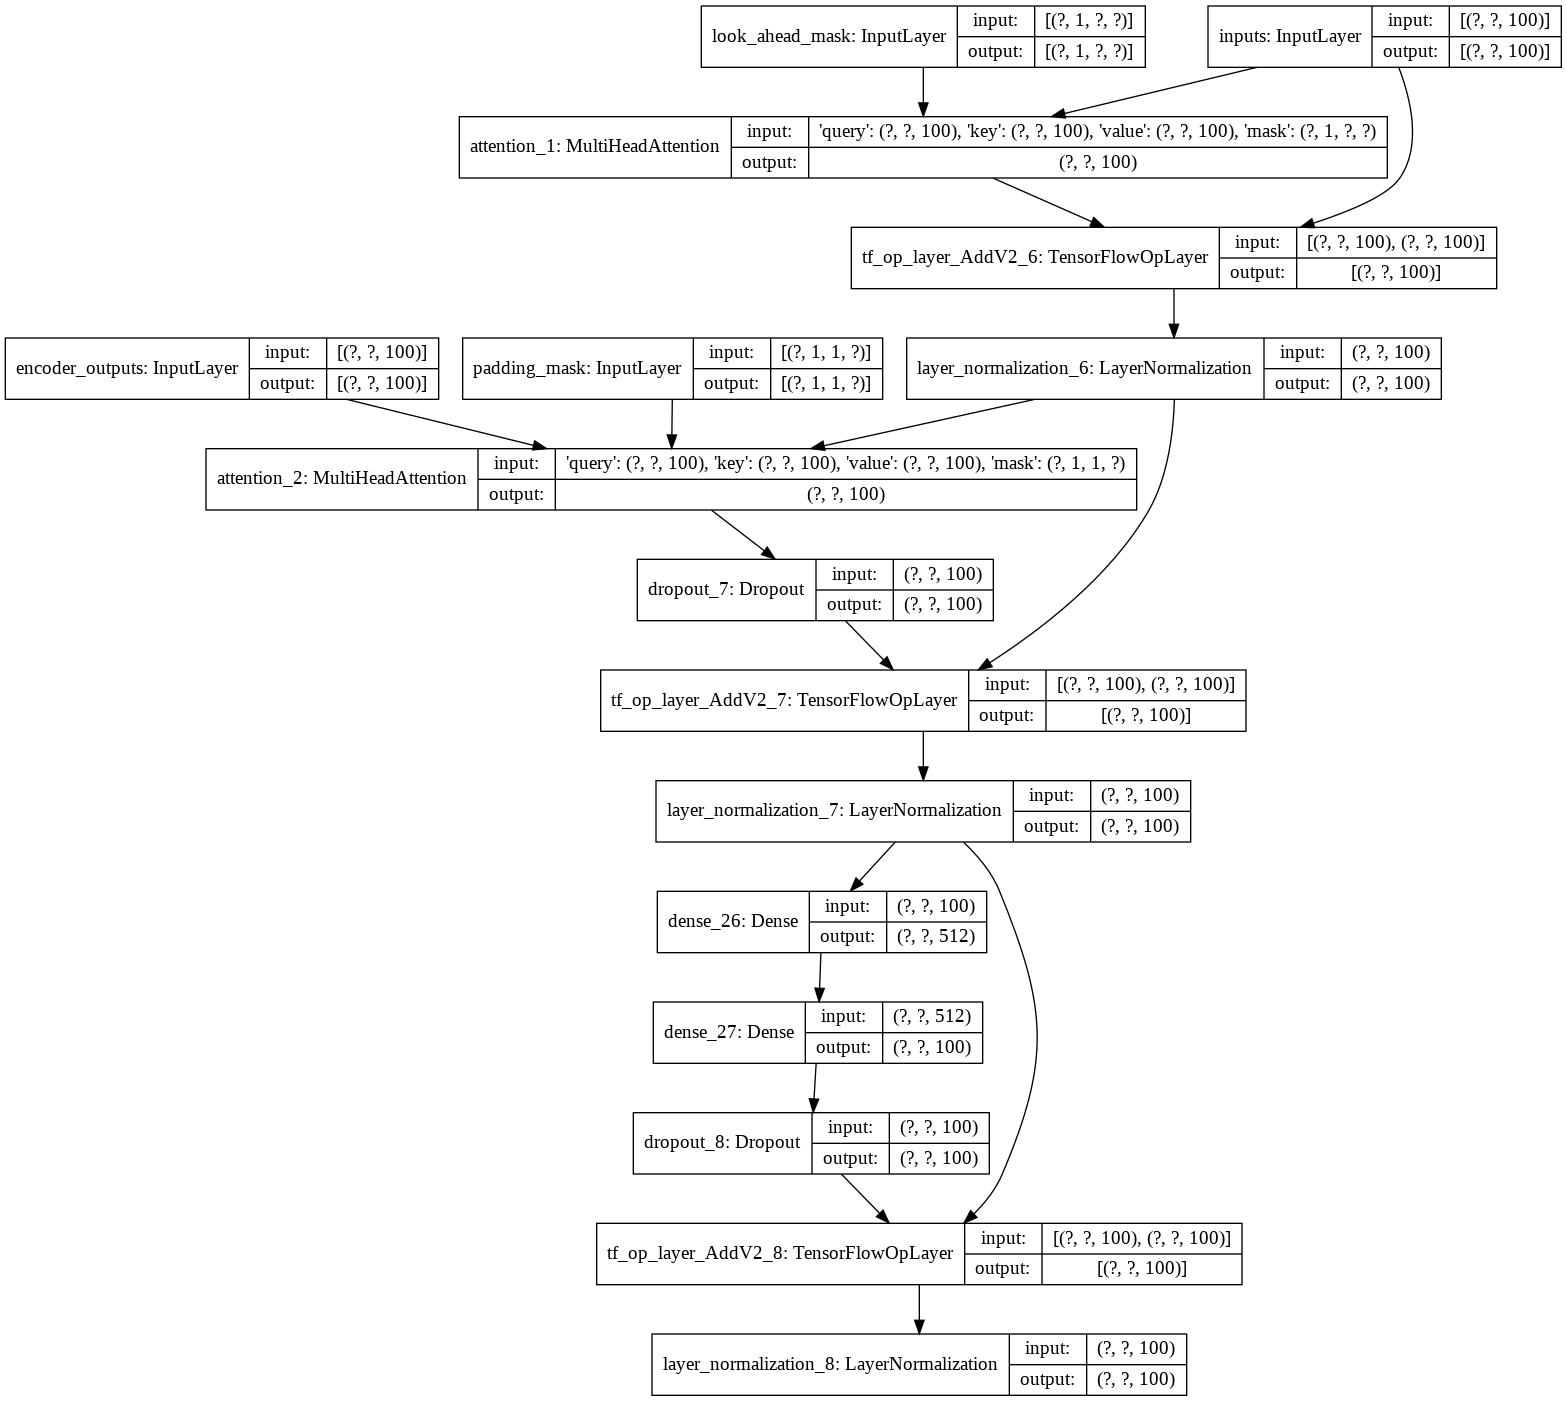

In [32]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=100,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings = tf.keras.layers.Embedding(len(word_index) + 3,
                          EMBEDDING_DIM,
                          # d_model,
                          # embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                          weights=[embedding_matrix],
                          input_length=MAX_LENGTH,
                          trainable=False)(inputs)  

  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

Decoder Layer inputs: Tensor("inputs_6:0", shape=(None, None, 100), dtype=float32)
Decoder Layer enc_outputs: Tensor("encoder_outputs_2:0", shape=(None, None, 100), dtype=float32)
Decoder Layer look_ahead_mask: Tensor("look_ahead_mask_2:0", shape=(None, 1, None, None), dtype=float32)
Decoder Layer padding_mask: Tensor("padding_mask_6:0", shape=(None, 1, 1, None), dtype=float32)
Decoder Layer attention1: Tensor("attention_1_2/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention1 - 2: Tensor("layer_normalization_9/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2: Tensor("attention_2_2/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 2: Tensor("dropout_10/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 3: Tensor("layer_normalization_10/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention3: Tensor("layer_normalization_10/Identity:0", shape=(None, None,

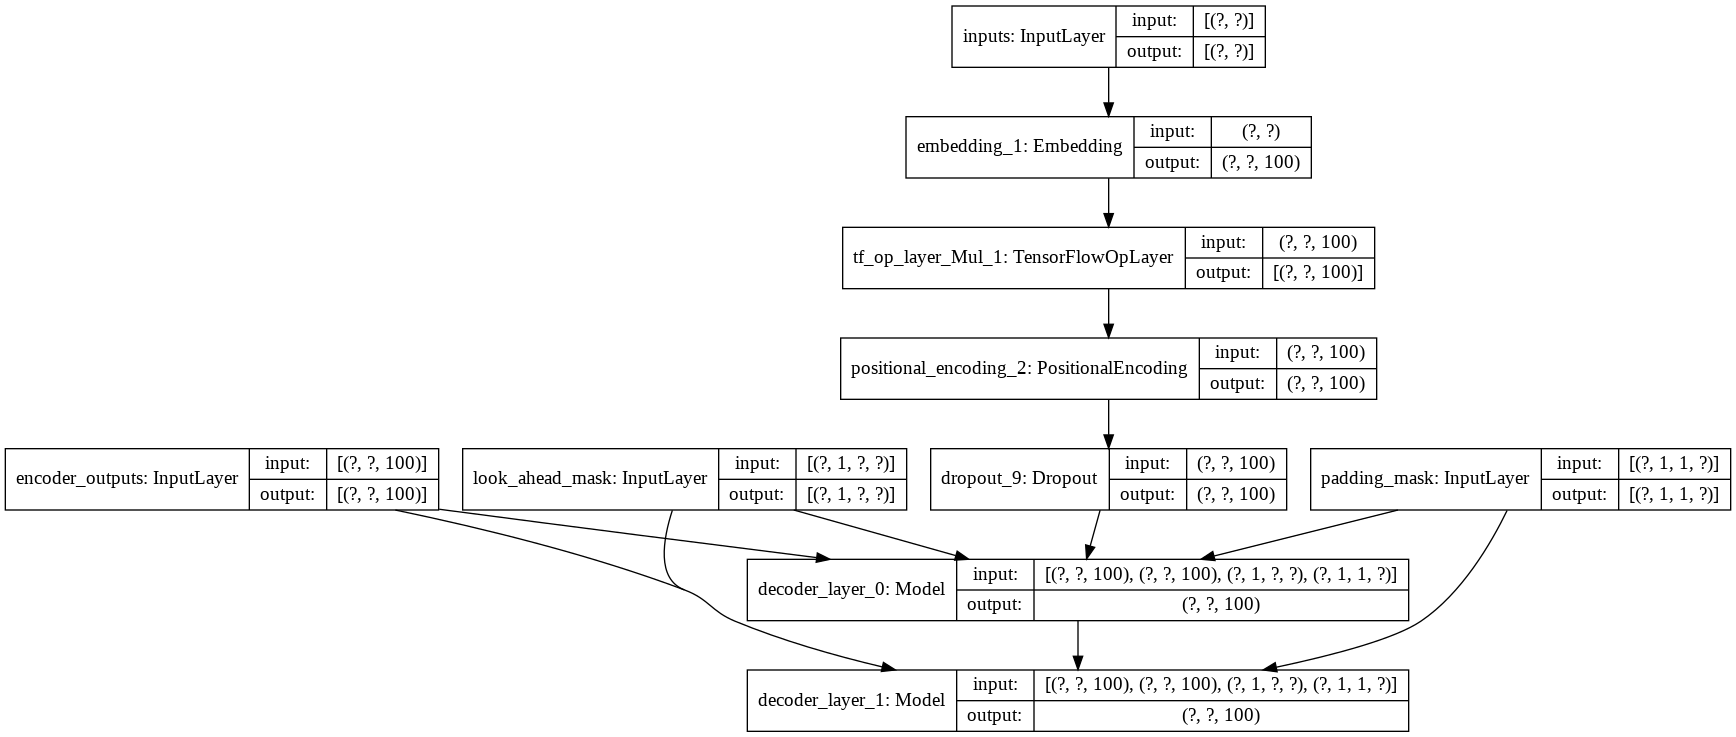

In [34]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=100,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [36]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

Decoder Layer inputs: Tensor("inputs_15:0", shape=(None, None, 100), dtype=float32)
Decoder Layer enc_outputs: Tensor("encoder_outputs_5:0", shape=(None, None, 100), dtype=float32)
Decoder Layer look_ahead_mask: Tensor("look_ahead_mask_6:0", shape=(None, 1, None, None), dtype=float32)
Decoder Layer padding_mask: Tensor("padding_mask_14:0", shape=(None, 1, 1, None), dtype=float32)
Decoder Layer attention1: Tensor("attention_1_4/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention1 - 2: Tensor("layer_normalization_23/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2: Tensor("attention_2_4/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 2: Tensor("dropout_24/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 3: Tensor("layer_normalization_24/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention3: Tensor("layer_normalization_24/Identity:0", shape=(None, No

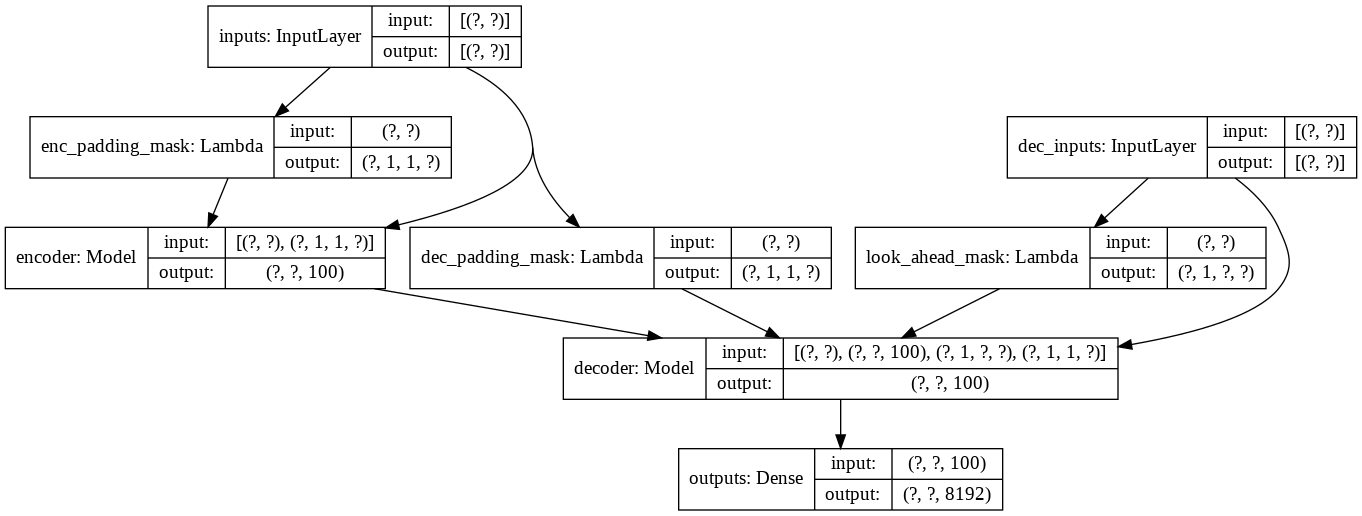

In [37]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=100,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model

Initialize the values for *num_layers, d_model, num_heads, dropout and units*

In [38]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 100
NUM_HEADS = 4
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

Decoder Layer inputs: Tensor("inputs_5:0", shape=(None, None, 100), dtype=float32)
Decoder Layer enc_outputs: Tensor("encoder_outputs_1:0", shape=(None, None, 100), dtype=float32)
Decoder Layer look_ahead_mask: Tensor("look_ahead_mask_2:0", shape=(None, 1, None, None), dtype=float32)
Decoder Layer padding_mask: Tensor("padding_mask_4:0", shape=(None, 1, 1, None), dtype=float32)
Decoder Layer attention1: Tensor("attention_1_1/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention1 - 2: Tensor("layer_normalization_4/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2: Tensor("attention_2/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 2: Tensor("dropout_6/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention2 - 3: Tensor("layer_normalization_5/Identity:0", shape=(None, None, 100), dtype=float32)
Decoder Layer attention3: Tensor("layer_normalization_5/Identity:0", shape=(None, None, 100)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [39]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = tf.Variable(d_model, name="d_model")
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
  def get_config(self):
        return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

Text(0.5, 0, 'Train Step')

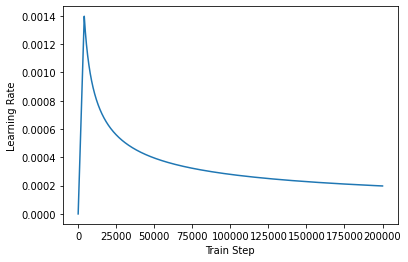

In [41]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Perplexity Score computation

In [45]:
K = tf.keras.backend
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self, name='perplexity', **kwargs):
        super(PerplexityMetric, self).__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.perplexity = self.add_weight(name='tp', initializer='zeros')

    # Consider uncommenting the decorator for a performance boost (?)
    # @tf.function
    def _calculate_perplexity(self, real, pred):
        # The next 4 lines zero-out the padding from loss calculations,
        # this follows the logic from: https://www.tensorflow.org/beta/tutorials/text/transformer#loss_and_metrics
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.cross_entropy(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        # Calculating the perplexity steps:
        step1 = K.mean(loss_, axis=-1)
        step2 = K.exp(step1)
        perplexity = K.mean(step2)

        return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
        # TODO:FIXME: handle sample_weight !
        if sample_weight is not None:
            print(
                "WARNING! Provided 'sample_weight' argument to the perplexity metric. Currently this is not handled and won't do anything differently..")
        perplexity = self._calculate_perplexity(y_true, y_pred)
        # Remember self.perplexity is a tensor (tf.Variable), so using simply "self.perplexity = perplexity" will result in error because of mixing EagerTensor and Graph operations
        self.perplexity.assign_add(perplexity)

    def result(self):
        return self.perplexity

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.perplexity.assign(0.)

### Compile Model


In [48]:
learning_rate = CustomSchedule(D_MODEL)
perplexity_class = PerplexityMetric()

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  masked_accuracy = tf.multiply(tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred), mask)
  return tf.divide(tf.reduce_sum(masked_accuracy), tf.reduce_sum(mask))  

def perplexity(y_true, y_pred):  
  return perplexity_class._calculate_perplexity(y_true, y_pred) 

# model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy, perplexity])

### Fit model

Train our transformer by simply calling `model.fit()`

In [64]:
EPOCHS = 30
# history = model.fit(train_dataset, epochs=EPOCHS)
history = model.fit(train_dataset, validation_data=validation_dataset, validation_batch_size=100, epochs=EPOCHS)

Epoch 1/30
4/4 [==============================] - 1s 304ms/step - loss: 1.4785 - accuracy: 0.1200 - perplexity: 8.4396 - val_loss: 1.3433 - val_accuracy: 0.1163 - val_perplexity: 6.5251
Epoch 2/30
4/4 [==============================] - 0s 22ms/step - loss: 1.4736 - accuracy: 0.1197 - perplexity: 8.3716 - val_loss: 1.3402 - val_accuracy: 0.1163 - val_perplexity: 6.4833
Epoch 3/30
4/4 [==============================] - 0s 22ms/step - loss: 1.4690 - accuracy: 0.1278 - perplexity: 8.2629 - val_loss: 1.3373 - val_accuracy: 0.1163 - val_perplexity: 6.4466
Epoch 4/30
4/4 [==============================] - 0s 23ms/step - loss: 1.4632 - accuracy: 0.1263 - perplexity: 8.1629 - val_loss: 1.3343 - val_accuracy: 0.1163 - val_perplexity: 6.4077
Epoch 5/30
4/4 [==============================] - 0s 23ms/step - loss: 1.4580 - accuracy: 0.1267 - perplexity: 8.1107 - val_loss: 1.3314 - val_accuracy: 0.1163 - val_perplexity: 6.3675
Epoch 6/30
4/4 [==============================] - 0s 22ms/step - loss: 1.4

## Save and load functions for the model

In [57]:
base_output_data_path = '/content/drive/My Drive/Berkeley/W266/final_project/'

def saveModelToFile(model, checkpoint_filepath):
  model_filename = base_output_data_path + checkpoint_filepath  
  model.save(model_filename)

def loadModelFromFile(checkpoint_filepath):
  model_filename = base_output_data_path + checkpoint_filepath  
  print('Model file path:\n', model_filename)
  model = tf.keras.models.load_model(model_filename, custom_objects={'CustomSchedule': CustomSchedule, 'loss_function':loss_function, 'accuracy':accuracy, 'perplexity':perplexity})

  return model

## Save model to file

In [58]:
model_file_path = 'save_model_test'
saveModelToFile(model, model_file_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Berkeley/W266/final_project/save_model_test/assets


In [76]:
import json 
def save_current_config(save_model_file_name):
  config_dict = {'start_token':START_TOKEN, 'end_token':END_TOKEN, 'save_model_file_name':save_model_file_name}
  config_filename = base_output_data_path + save_model_file_name + '/config.txt'
  with open(config_filename, 'w') as f: 
    json.dump(config_dict, f)   

save_current_config(model_file_path)

In [59]:
saved_model = loadModelFromFile(model_file_path)

Model file path:
 /content/drive/My Drive/Berkeley/W266/final_project/save_model_test


In [77]:
import json 
def load_current_config(save_model_file_name):
  config_dict = {'start_token':START_TOKEN, 'end_token':END_TOKEN, 'save_model_file_name':save_model_file_name}
  config_filename = base_output_data_path + save_model_file_name + '/config.txt'
  with open(config_filename) as f: 
    config_dict = json.load(f)   
  return config_dict

current_config = load_current_config(model_file_path)
print(current_config, ',', type(current_config.get('start_token')))
START_TOKEN = current_config.get('start_token')
END_TOKEN = current_config.get('end_token')
print(START_TOKEN, ',', END_TOKEN)

{'start_token': [903], 'end_token': [904], 'save_model_file_name': 'save_model_test'} , <class 'list'>
[903] , [904]


In [60]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 100)    378124      inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

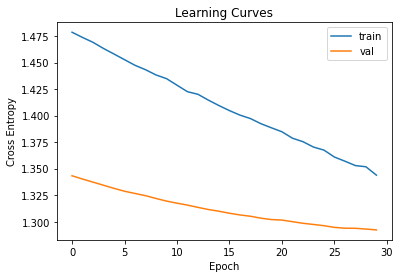

In [65]:
import matplotlib.pyplot as pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

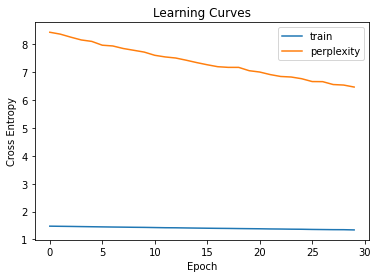

In [66]:
# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['perplexity'], label='perplexity')
pyplot.legend()
pyplot.show()

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [ ]:
def tokenize_sentence(input_sentence):
  input_sentence = preprocess_sentence(input_sentence)

  inputs = []
  inputs.append(input_sentence)
  tokenized_inputs = []
  inputs = tokenizer.texts_to_sequences(inputs)
  for sentence1 in inputs:
    # tokenize sentence
    sentence1 = START_TOKEN + sentence1 + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)

  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  return tokenized_inputs[0]

input_sentence = 'well , i thought we d start with pronunciation , if that s okay with you .'
print(tokenize_sentence(input_sentence))

In [ ]:
print(questions[0])
print(answers[0])
print(sequenced_questions[0])
print(sequenced_answers[0])
print(sequence_to_word_dict.get(474))

In [ ]:
def evaluate(sentence):
  sentence = tokenize_sentence(sentence)

  sentence = tf.expand_dims(sentence, axis=0)
  output = tf.expand_dims(START_TOKEN, 0)
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)
  np_prediction = prediction.numpy()

  predicted_sentence = ''
  for i in np_prediction[1:]:
    predicted_sentence = predicted_sentence + sequence_to_word_dict.get(i) + ' '

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

output = predict('what is your name')  


Let's test our model!

In [ ]:
# feed the model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
  sentence = predict(sentence)
  print('')

# Test data runs

In [72]:
TEST_BATCH_SIZE=10
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': test_questions[:500],
        'dec_inputs': test_answers[:500, :-1]
    },
    {
        'outputs': test_answers[:500, 1:]
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [73]:
test_predict_output = model.predict(test_dataset)

In [74]:
print(test_predict_output.shape)

(22, 39, 905)


In [ ]:
test_questions_input = []
test_answer_output = []
test_questions_predictions = []

def get_word_sentence(input_sentence_sequence):
  print(input_sentence_sequence)
  current_question = ''
  for index in range(0, len(input_sentence_sequence)):
    print(input_sentence_sequence)
    if input_sentence_sequence[index] == START_TOKEN:
      continue
    elif input_sentence_sequence[index] == END_TOKEN:
      break
    else:
      current_question += current_question + sequence_to_word_dict[input_sentence_sequence[index]] + ' '
  return current_question

for index in range(0, 1):
  print(get_word_sentence(test_questions[index]))